In [1]:
# NLTK
import nltk
from nltk import tokenize, word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.text import Text
from nltk.corpus import brown, stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import roc_curve

# TQDM
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
from distutils.command.build import build

# General Libraries
import requests
import re
import pandas as pd
import spacy
import pymysql
import string
import numpy as np
from sqlalchemy import create_engine

# Sentiment Analyser
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
host='database-1.cg01lulzqvm7.ap-southeast-1.rds.amazonaws.com'
port=int(3306)
user='zhenyuen'
passw = 'zhenyuen488'
database = 'ANL488_database_2'

In [3]:
connection = pymysql.connect(host = f'{host}',  
                             user = f'{user}', 
                             password = f'{passw}',
                             database = f'{database}')

In [4]:
glassdoor_data = pd.read_sql_query('''select * from Company_Glassdoor_Data''', connection)
glassdoor_data.head()

c:\Users\zheny\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,headline,date,year exp,score,pros,cons,company,position
0,Great company to work,2022-09-08,"Current Employee, less than 1 year",5.0,"Great Benefit, no 996, good working environment",sometimes the communication still in Chinese b...,TikTok,Anonymous Employee
1,Good but not great. Self driven is a must,2022-09-08,"Current Employee, more than 1 year",4.0,Good benefits and fast growing,Need to be very self driven and street smart,TikTok,Business Operations Analyst
2,"A fast growing, diverse and inclusive workplace",2022-09-07,Current Employee,5.0,- Great emphasis on staff well being\r\n- Regu...,- Infrastructure can be further improved (Faci...,TikTok,Anonymous Employee
3,PM,2022-08-29,Current Employee,5.0,Good Atmosphere and excellent teamwork,So far so good and nothing special to mention,TikTok,Product Designer
4,Nice for u if you like coop with young people,2022-08-21,"Current Employee, more than 1 year",4.0,"the company is filled with young people, very ...",Might need to OT when you oncall\r\nsome bosse...,TikTok,Quality Assurance Engineer


In [5]:
glassdoor_data[['type', 'duration']] = glassdoor_data['year exp'].str.split(',', expand=True)

In [6]:
glassdoor_data.head()

,headline,date,year exp,score,pros,cons,company,position,type,duration
0,Great company to work,2022-09-08,"Current Employee, less than 1 year",5.0,"Great Benefit, no 996, good working environment",sometimes the communication still in Chinese b...,TikTok,Anonymous Employee,Current Employee,less than 1 year
1,Good but not great. Self driven is a must,2022-09-08,"Current Employee, more than 1 year",4.0,Good benefits and fast growing,Need to be very self driven and street smart,TikTok,Business Operations Analyst,Current Employee,more than 1 year
2,"A fast growing, diverse and inclusive workplace",2022-09-07,Current Employee,5.0,- Great emphasis on staff well being\r\n- Regu...,- Infrastructure can be further improved (Faci...,TikTok,Anonymous Employee,Current Employee,None
3,PM,2022-08-29,Current Employee,5.0,Good Atmosphere and excellent teamwork,So far so good and nothing special to mention,TikTok,Product Designer,Current Employee,None
4,Nice for u if you like coop with young people,2022-08-21,"Current Employee, more than 1 year",4.0,"the company is filled with young people, very ...",Might need to OT when you oncall\r\nsome bosse...,TikTok,Quality Assurance Engineer,Current Employee,more than 1 year


In [7]:
glassdoor_data['date'] = pd.to_datetime(glassdoor_data['date']).dt.date
glassdoor_data['month'] = pd.to_datetime(glassdoor_data['date']).dt.month
glassdoor_data['year'] = pd.to_datetime(glassdoor_data['date']).dt.year

In [8]:
glassdoor_data.groupby(['company'])['headline'].count().reset_index(name = 'count')
glassdoor_data['month_year'] = glassdoor_data['date'].apply(lambda x: x.strftime('%B-%Y')) 
glassdoor_data.sort_values('date', ascending = True, inplace = True)

### Sentiment Analysis

In [9]:
# =================================
# Preprocessing
# =================================
glassdoor_data['reviews'] = glassdoor_data['pros'] + glassdoor_data['cons']

# Convert to lowercase
glassdoor_data['reviews'] = glassdoor_data['reviews'].str.lower()

# Remove Stop Words
stop = stopwords.words('english')
glassdoor_data['reviews'] = glassdoor_data['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Remove punctuations
glassdoor_data["reviews"] = glassdoor_data['reviews'].str.replace('[^\w\s]','')

C:\Users\zheny\AppData\Local\Temp\ipykernel_10000\111074284.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  glassdoor_data["reviews"] = glassdoor_data['reviews'].str.replace('[^\w\s]','')


In [10]:
# Lemmentisation
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

glassdoor_data['reviews'] = glassdoor_data['reviews'].apply(lemmatize_text)
glassdoor_data['reviews'] = glassdoor_data['reviews'].apply(', '.join)

glassdoor_data.head()

,headline,date,year exp,score,pros,cons,company,position,type,duration,month,year,month_year,reviews
1101,Good Benefits but too resistant to changes,2009-06-11,Current Employee,2.0,"Flexible benefits, employee engagement program...","pay is low compared to market average, long se...",American Express,Credit Analyst,Current Employee,None,6,2009,June-2009,"flexible, benefit, employee, engagement, progr..."
1100,Finance Manager,2010-04-18,Current Employee,4.0,good working environment for all,More talk on lateral movements than reality,American Express,Fianance Manager,Current Employee,None,4,2010,April-2010,"good, working, environment, allmore, talk, lat..."
1099,Great Brand,2010-12-07,Former Employee,4.0,"Great brand to work on, great benefits, exciti...",Stressful environment with aggressive deadline...,American Express,,Former Employee,None,12,2010,December-2010,"great, brand, work, on, great, benefit, exciti..."
1098,"decent environment, good work life balance",2012-09-04,"Former Employee, more than 5 years",4.0,good employee benefits. good brand,"continuous reorganization, climbing up the lad...",American Express,Manager Analytics,Former Employee,more than 5 years,9,2012,September-2012,"good, employee, benefit, good, brandcontinuous..."
1097,Nice company to work for,2012-11-08,"Former Employee, more than 8 years",4.0,Not extremely stressful. Nice benefits,Has diversity issues when it comes to hiring,American Express,Business Development Executive,Former Employee,more than 8 years,11,2012,November-2012,"extremely, stressful, nice, benefitshas, diver..."


In [11]:
glassdoor_data['tokenize_reviews'] = glassdoor_data['reviews'].apply(lambda x: tokenize.sent_tokenize(x))

In [12]:
glassdoor_data.head()

,headline,date,year exp,score,pros,cons,company,position,type,duration,month,year,month_year,reviews,tokenize_reviews
1101,Good Benefits but too resistant to changes,2009-06-11,Current Employee,2.0,"Flexible benefits, employee engagement program...","pay is low compared to market average, long se...",American Express,Credit Analyst,Current Employee,None,6,2009,June-2009,"flexible, benefit, employee, engagement, progr...","[flexible, benefit, employee, engagement, prog..."
1100,Finance Manager,2010-04-18,Current Employee,4.0,good working environment for all,More talk on lateral movements than reality,American Express,Fianance Manager,Current Employee,None,4,2010,April-2010,"good, working, environment, allmore, talk, lat...","[good, working, environment, allmore, talk, la..."
1099,Great Brand,2010-12-07,Former Employee,4.0,"Great brand to work on, great benefits, exciti...",Stressful environment with aggressive deadline...,American Express,,Former Employee,None,12,2010,December-2010,"great, brand, work, on, great, benefit, exciti...","[great, brand, work, on, great, benefit, excit..."
1098,"decent environment, good work life balance",2012-09-04,"Former Employee, more than 5 years",4.0,good employee benefits. good brand,"continuous reorganization, climbing up the lad...",American Express,Manager Analytics,Former Employee,more than 5 years,9,2012,September-2012,"good, employee, benefit, good, brandcontinuous...","[good, employee, benefit, good, brandcontinuou..."
1097,Nice company to work for,2012-11-08,"Former Employee, more than 8 years",4.0,Not extremely stressful. Nice benefits,Has diversity issues when it comes to hiring,American Express,Business Development Executive,Former Employee,more than 8 years,11,2012,November-2012,"extremely, stressful, nice, benefitshas, diver...","[extremely, stressful, nice, benefitshas, dive..."


In [13]:
analyzer = SentimentIntensityAnalyzer()

sentiments_list = list()

for review in glassdoor_data['reviews'].tolist():
    sentence_list = tokenize.sent_tokenize(review)
    sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}
        
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        sentiments['compound'] += vs['compound']
        sentiments['neg'] += vs['neg']
        sentiments['neu'] += vs['neu']
        sentiments['pos'] += vs['pos']
            
    sentiments['compound'] = sentiments['compound'] / len(sentence_list)
    sentiments['neg'] = sentiments['neg'] / len(sentence_list)
    sentiments['neu'] = sentiments['neu'] / len(sentence_list)
    sentiments['pos'] = sentiments['pos'] / len(sentence_list)
    
    sentiments_list.append(sentiments)  # add this line

In [14]:
glassdoor_data = glassdoor_data.join(pd.DataFrame(sentiments_list))
glassdoor_data.head()

,headline,date,year exp,score,pros,cons,company,position,type,duration,month,year,month_year,reviews,tokenize_reviews,compound,neg,neu,pos
1101,Good Benefits but too resistant to changes,2009-06-11,Current Employee,2.0,"Flexible benefits, employee engagement program...","pay is low compared to market average, long se...",American Express,Credit Analyst,Current Employee,None,6,2009,June-2009,"flexible, benefit, employee, engagement, progr...","[flexible, benefit, employee, engagement, prog...",-0.7650,0.452,0.548,0.000
1100,Finance Manager,2010-04-18,Current Employee,4.0,good working environment for all,More talk on lateral movements than reality,American Express,Fianance Manager,Current Employee,None,4,2010,April-2010,"good, working, environment, allmore, talk, lat...","[good, working, environment, allmore, talk, la...",0.6249,0.000,0.594,0.406
1099,Great Brand,2010-12-07,Former Employee,4.0,"Great brand to work on, great benefits, exciti...",Stressful environment with aggressive deadline...,American Express,,Former Employee,None,12,2010,December-2010,"great, brand, work, on, great, benefit, exciti...","[great, brand, work, on, great, benefit, excit...",0.4404,0.000,0.805,0.195
1098,"decent environment, good work life balance",2012-09-04,"Former Employee, more than 5 years",4.0,good employee benefits. good brand,"continuous reorganization, climbing up the lad...",American Express,Manager Analytics,Former Employee,more than 5 years,9,2012,September-2012,"good, employee, benefit, good, brandcontinuous...","[good, employee, benefit, good, brandcontinuou...",0.5267,0.115,0.492,0.393
1097,Nice company to work for,2012-11-08,"Former Employee, more than 8 years",4.0,Not extremely stressful. Nice benefits,Has diversity issues when it comes to hiring,American Express,Business Development Executive,Former Employee,more than 8 years,11,2012,November-2012,"extremely, stressful, nice, benefitshas, diver...","[extremely, stressful, nice, benefitshas, dive...",0.2263,0.000,0.808,0.192


### Emotion Lexicon

In [15]:
emotion_lexicon_df = pd.read_sql_query('''select * from NRC_Emotion_Lexicon''', connection)
emotion_lexicon_df.head()

c:\Users\zheny\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,aback,0,0,0,0,0,0,0,0,0,0
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,1,0,0,0,1,0,1,0,0
3,abandoned,0,1,1,0,0,1,0,1,0,0
4,abandonment,0,1,1,0,0,1,0,1,1,0


In [16]:
emotion_dict = emotion_lexicon_df.to_dict('records')

In [17]:
emotions_df = pd.DataFrame(0, index=glassdoor_data.index, columns=emotion_lexicon_df.columns)
emotions_df

,Word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
1101,0,0,0,0,0,0,0,0,0,0,0
1100,0,0,0,0,0,0,0,0,0,0,0
1099,0,0,0,0,0,0,0,0,0,0,0
1098,0,0,0,0,0,0,0,0,0,0,0
1097,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1552,0,0,0,0,0,0,0,0,0,0,0
1560,0,0,0,0,0,0,0,0,0,0,0
1562,0,0,0,0,0,0,0,0,0,0,0
1102,0,0,0,0,0,0,0,0,0,0,0


In [18]:
# def transform_list(x):
#     emotion_list = [emotion_lexicon_df[emotion_lexicon_df['Word'] == i].to_dict('records')[0] for i in x if emotion_lexicon_df[emotion_lexicon_df['Word'] == i].to_dict('records') != []]
#     return emotion_list

In [19]:
def lemmatize_text(text):
    stemmer = SnowballStemmer('english')
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    x = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text) if w_tokenizer.tokenize(text) != ',']
    x = [''.join(c for c in s if c not in string.punctuation) for s in x]
    x = [stemmer.stem(word.lower()) for word in x]
    
    return x
def transform_list(x):
    emotion_list = [next((item for item in emotion_dict if item["Word"] == i), None) for i in x]
    return emotion_list

def sum_dict_values(dict_list):
    dict_list = [x for x in dict_list if x is not None]
    result = {}
    for d in dict_list:
        for k, v in d.items():
            if k != 'Word' and isinstance(v, int):
                result[k] = result.get(k, 0) + v
    return result

In [20]:
glassdoor_data['emotions'] = glassdoor_data['reviews'].apply(lemmatize_text)
glassdoor_data['emotions'] = glassdoor_data['emotions'].apply(transform_list)
glassdoor_data['emotions'] = glassdoor_data['emotions'].apply(sum_dict_values)
glassdoor_data = pd.concat([glassdoor_data, glassdoor_data['emotions'].apply(pd.Series)], axis = 1)

C:\Users\zheny\AppData\Local\Temp\ipykernel_10000\2062385468.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  glassdoor_data = pd.concat([glassdoor_data, glassdoor_data['emotions'].apply(pd.Series)], axis = 1)
C:\Users\zheny\AppData\Local\Temp\ipykernel_10000\2062385468.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  glassdoor_data = pd.concat([glassdoor_data, glassdoor_data['emotions'].apply(pd.Series)], axis = 1)
C:\Users\zheny\AppData\Local\Temp\ipykernel_10000\2062385468.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  glassdoor_data = pd.concat([glassdoor_data, glassdoor_data['emotions'].apply(pd.Series)], axis = 1)
C:\Users\z

In [21]:
glassdoor_data.head()

,headline,date,year exp,score,pros,cons,company,position,type,duration,...,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
1101,Good Benefits but too resistant to changes,2009-06-11,Current Employee,2.0,"Flexible benefits, employee engagement program...","pay is low compared to market average, long se...",American Express,Credit Analyst,Current Employee,None,...,2.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0
1100,Finance Manager,2010-04-18,Current Employee,4.0,good working environment for all,More talk on lateral movements than reality,American Express,Fianance Manager,Current Employee,None,...,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
1099,Great Brand,2010-12-07,Former Employee,4.0,"Great brand to work on, great benefits, exciti...",Stressful environment with aggressive deadline...,American Express,,Former Employee,None,...,3.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
1098,"decent environment, good work life balance",2012-09-04,"Former Employee, more than 5 years",4.0,good employee benefits. good brand,"continuous reorganization, climbing up the lad...",American Express,Manager Analytics,Former Employee,more than 5 years,...,3.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,2.0
1097,Nice company to work for,2012-11-08,"Former Employee, more than 8 years",4.0,Not extremely stressful. Nice benefits,Has diversity issues when it comes to hiring,American Express,Business Development Executive,Former Employee,more than 8 years,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [22]:
stemmer = SnowballStemmer('english')

# TQDM as progress bar
with tqdm(total=len(list(glassdoor_data.iterrows()))) as pbar:
    
    # Iterate over reviews
    for index, row in glassdoor_data.iterrows():
        # Update progress bar
        pbar.update(1)
        
        # Tokenise reviews
        document = word_tokenize(glassdoor_data.loc[index]['reviews'])
        
        # Iterate over words in reviews
        for word in document:
            
            # Stem and convert to lower
            word = stemmer.stem(word.lower())
            
            # Match emotion score with NRC emotions database
            emo_score = emotion_lexicon_df[emotion_lexicon_df['Word'] == word]
            if not emo_score.empty:
                for emotion in list(emotion_lexicon_df.columns.drop("Word")):
                    
                    # Append emotions score
                    emotions_df.at[index, emotion] += emo_score[emotion]

C:\Users\zheny\AppData\Local\Temp\ipykernel_10000\3473149856.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(list(glassdoor_data.iterrows()))) as pbar:


  0%|          | 0/1710 [00:00<?, ?it/s]

In [23]:
emotions_df

,Word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
1101,0,2,1,0,2,0,1,0,1,0,1
1100,0,3,0,0,1,0,0,1,0,1,1
1099,0,3,2,0,0,0,0,0,1,0,2
1098,0,3,0,0,2,0,0,2,0,2,2
1097,0,1,1,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1552,0,1,0,0,1,0,0,1,0,0,1
1560,0,1,0,0,1,0,0,1,0,0,1
1562,0,0,2,2,0,2,1,0,1,0,0
1102,0,0,0,0,0,0,0,0,0,0,0


In [24]:
exclusive_list = ['Anger', 'Fear', 'Disgust']
openness_list = ['Joy', 'Trust', 'Anticipation']

emotions_df['is_exclusive'] = emotions_df[exclusive_list].sum(axis = 1)
emotions_df['is_open'] = emotions_df[openness_list].sum(axis = 1)

In [25]:
emotions_df['exclusive_openness'] = emotions_df.apply(lambda x: 'exclusive' if 
                                                      (x['is_exclusive'] > x['is_open']) else 'open', axis = 1)
emotions_df

,Word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust,is_exclusive,is_open,exclusive_openness
1101,0,2,1,0,2,0,1,0,1,0,1,1,3,open
1100,0,3,0,0,1,0,0,1,0,1,1,0,3,open
1099,0,3,2,0,0,0,0,0,1,0,2,0,2,open
1098,0,3,0,0,2,0,0,2,0,2,2,0,6,open
1097,0,1,1,0,1,0,0,1,0,0,1,0,3,open
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552,0,1,0,0,1,0,0,1,0,0,1,0,3,open
1560,0,1,0,0,1,0,0,1,0,0,1,0,3,open
1562,0,0,2,2,0,2,1,0,1,0,0,5,0,exclusive
1102,0,0,0,0,0,0,0,0,0,0,0,0,0,open


In [26]:
glassdoor_data = pd.concat([glassdoor_data, emotions_df], axis = 1)

In [27]:
glassdoor_data

,headline,date,year exp,score,pros,cons,company,position,type,duration,...,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust,is_exclusive,is_open,exclusive_openness
1101,Good Benefits but too resistant to changes,2009-06-11,Current Employee,2.0,"Flexible benefits, employee engagement program...","pay is low compared to market average, long se...",American Express,Credit Analyst,Current Employee,None,...,2,0,1,0,1,0,1,1,3,open
1100,Finance Manager,2010-04-18,Current Employee,4.0,good working environment for all,More talk on lateral movements than reality,American Express,Fianance Manager,Current Employee,None,...,1,0,0,1,0,1,1,0,3,open
1099,Great Brand,2010-12-07,Former Employee,4.0,"Great brand to work on, great benefits, exciti...",Stressful environment with aggressive deadline...,American Express,,Former Employee,None,...,0,0,0,0,1,0,2,0,2,open
1098,"decent environment, good work life balance",2012-09-04,"Former Employee, more than 5 years",4.0,good employee benefits. good brand,"continuous reorganization, climbing up the lad...",American Express,Manager Analytics,Former Employee,more than 5 years,...,2,0,0,2,0,2,2,0,6,open
1097,Nice company to work for,2012-11-08,"Former Employee, more than 8 years",4.0,Not extremely stressful. Nice benefits,Has diversity issues when it comes to hiring,American Express,Business Development Executive,Former Employee,more than 8 years,...,1,0,0,1,0,0,1,0,3,open
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552,Great Company,2022-09-10,"Former Employee, more than 1 year",4.0,Flexible hours\nGreat location\nManagers,Ok pay under staffed customers can be rude,Walmart,Front End Cashier,Former Employee,more than 1 year,...,1,0,0,1,0,0,1,0,3,open
1560,Good pay,2022-09-10,Current Employee,5.0,It pays pretty well considering you don’t need...,Can be hard to meet goals,Walmart,Desk Clerk,Current Employee,None,...,1,0,0,1,0,0,1,0,3,open
1562,I wish upper management could walk a week in o...,2022-09-10,"Current Employee, more than 5 years",5.0,The people I work with are amazing!,Sometimes the costumers are grumpy. Who can bl...,Walmart,Certified Pharmacy Technician,Current Employee,more than 5 years,...,0,2,1,0,1,0,0,5,0,exclusive
1102,Good place to work,2022-09-11,"Current Employee, less than 1 year",5.0,"work life balance, explore new opportunities",no such cons in this role,American Express,Process Manager,Current Employee,less than 1 year,...,0,0,0,0,0,0,0,0,0,open


In [28]:
glassdoor_data.columns

Index(['headline', 'date', 'year exp', 'score', 'pros', 'cons', 'company',
       'position', 'type', 'duration', 'month', 'year', 'month_year',
       'reviews', 'tokenize_reviews', 'compound', 'neg', 'neu', 'pos',
       'emotions', 'Positive', 'Negative', 'Anger', 'Anticipation', 'Disgust',
       'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust', 'Word', 'Positive',
       'Negative', 'Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy',
       'Sadness', 'Surprise', 'Trust', 'is_exclusive', 'is_open',
       'exclusive_openness'],
      dtype='object')

### Machine Learning Classification for Brand Personalities

In [29]:
from personality_evaluation import *

In [30]:
MBTI_personalities = pd.read_sql_query('''select * from Myers_Briggs_Type_Indicator''', connection)
MBTI_personalities.head()

c:\Users\zheny\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [31]:
MBTI_personalities['Introvert_Extrovert'] = MBTI_personalities['type'].apply(lambda x: 'Introvert' if "I" in x else "Extrovert")
MBTI_personalities['Intuition_Sensing'] = MBTI_personalities['type'].apply(lambda x: 'Intuition' if "N" in x else "Sensing")
MBTI_personalities['Thinking_Feeling'] = MBTI_personalities['type'].apply(lambda x: 'Thinking' if "T" in x else "Feeling")
MBTI_personalities['Judging_Perceiving'] = MBTI_personalities['type'].apply(lambda x: 'Judging' if "J" in x else "Perceiving")

In [32]:
# Convert to lowercase

MBTI_personalities['posts'] = MBTI_personalities['posts'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
MBTI_personalities['posts'] = MBTI_personalities['posts'].apply(lambda x: re.split('http:\/\/.*', str(x))[0])

MBTI_personalities['posts'] = MBTI_personalities['posts'].str.lower()

# Remove Stop Words
stop = stopwords.words('english')
MBTI_personalities['posts'] = MBTI_personalities['posts'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Remove punctuations
MBTI_personalities["posts"] = MBTI_personalities['posts'].str.replace('[^\w\s]',' ')

C:\Users\zheny\AppData\Local\Temp\ipykernel_10000\906938670.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  MBTI_personalities["posts"] = MBTI_personalities['posts'].str.replace('[^\w\s]',' ')


#### Self Written Modules

In [33]:
def xgboost_classifier(df, column, classify_text):
    """
    Self written feature to run the XGBoost model. Input data and specifying the 
    column that contains the labelled data
    """
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.feature_extraction.text import CountVectorizer
    from xgboost import XGBClassifier
    
    df['Label'] = df[column].apply(lambda x: 1 if x==classify_text else 0)
    
    cv = CountVectorizer(max_features=5000, encoding="utf-8",  
        ngram_range = (1,3),  
        token_pattern = "[A-Za-z_][A-Za-z\d_]*")
    
    X = cv.fit_transform(df.posts).toarray()
    
    y = df['Label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
        test_size=0.2, 
        random_state=0)

    count_df = pd.DataFrame(X_train, columns=cv.get_feature_names())

    count_df['etiket'] = y_train
    
    model = XGBClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data

    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    # evaluate predictions

    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    y_proba = model.predict_proba(X_test)
    
    return model, y_test, y_pred, y_proba

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", color_codes=True)

def get_confusion_matrix(y_test, y_predicted, title):
    """
    Return the confusion matrix using confusion matrix function in sklearn.metrics
    Matplotlib to visualise confusion matrix in table form
    """
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(15,10))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title(title, fontsize = 20)
    plt.ylabel('True label', fontsize = 20)
    plt.xlabel('Predicted label', fontsize = 20)
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, fontsize = 20)
    plt.yticks(tick_marks, classNames, fontsize = 20)
    s = [['TN','FP'], ['FN', 'TP']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20)
    plt.grid(False)
    plt.show()

In [35]:
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

def plot_sklearn_roc_curve(y_real, y_pred):
    """
    Plot the ROC AUC Curve using RocCurveDisplay an inbuilt feature from sklearn
    """
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')
    plt.plot([0, 1], [0, 1], color = 'g')


In [36]:
# Plot combine ROC AUC Curve
def plot_AUC(title, fpr1, tpr1, fpr2, tpr2, p_fpr, p_tpr):
    """
    Plot the AUC curve for 2 different models
    Parameters take in fpr1, tpr1 for first model, fpr2 and tpr2 for second model
    p_fpr, p_tpr will give us the average line.
    """
    import matplotlib.pyplot as plt
    plt.style.use('seaborn')

    # plot roc curves
    plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Naive Bayes')
    plt.plot(fpr2, tpr2, linestyle='--',color='green', label='XGBoost')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    # title
    plt.title(f'{title} ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show();

In [37]:
def get_classification_report(y_test, y_pred):
    """
    Print classification metrics by first getting the true negative, 
    true positive, false negative and false positive 
    """
    cm=confusion_matrix(y_test, y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2*((recall * precision)/(recall + precision))
    specificity = TN / (TN + FP)
    false_positive_rate = FP / (TN + FP)
    false_negative_rate = FN / (TP + FN)
    
    print(f"Accuracy = {accuracy}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"F1_score = {f1_score}")
    print(f"Specificity = {specificity}")
    print(f"False Positive Rate = {false_positive_rate}")
    print(f"False Negative Rate = {false_negative_rate}")

In [38]:
def show_most_informative_features_in_list(classifier, n=10):
    from nltk.corpus import wordnet
    """
    Return a nested list of the "most informative" features 
    used by the classifier along with it's predominant labels
    """
    cpdist = classifier._feature_probdist       # probability distribution for feature values given labels
    feature_list = []
    for (fname, fval) in classifier.most_informative_features(100):
        def labelprob(l):
            return cpdist[l, fname].prob(fval)
        labels = sorted([l for l in classifier._labels if fval in cpdist[l, fname].samples()], 
                        key=labelprob)
        feature_list.append([fname, labels[-1]])
    
    feature_df = pd.DataFrame(feature_list, columns = ['word', 'type'])
    # Check if word is english word
    feature_df['english_word'] = feature_df['word'].apply(lambda x: True if wordnet.synsets(x) else False)
    
    # Filter to only those that are english word
    feature_df = feature_df[feature_df['english_word'] == True]
    
    # Print list of words
    print(feature_df['type'].unique()[0], ": ",
          list(feature_df.loc[feature_df['type'] == feature_df['type'].unique()[0]].head(n)['word']))
    
    print(feature_df['type'].unique()[1], ": ",
          list(feature_df.loc[feature_df['type'] == feature_df['type'].unique()[1]].head(n)['word']))
    
    return feature_df

### Introvert-Extrovert

##### Naive Bayes

In [39]:
intro_extro_df = balance_dataset(MBTI_personalities, 'Introvert_Extrovert')
bag_of_words_features = build_bag_of_words_features_filtered

features = feature_creation(intro_extro_df, bag_of_words_features, 'Introvert_Extrovert')
train, test = train_test(features)

IntroExtroClassifier = NaiveBayesClassifier.train(train)

training_accuracy = nltk.classify.util.accuracy(IntroExtroClassifier, train)*100
testing_accuracy = nltk.classify.util.accuracy(IntroExtroClassifier, test)*100
print(f"Training accuracy is: {training_accuracy}")
print(f"Testing accuracy is: {testing_accuracy}")

3998
Training accuracy is: 82.39524702939337
Testing accuracy is: 51.125


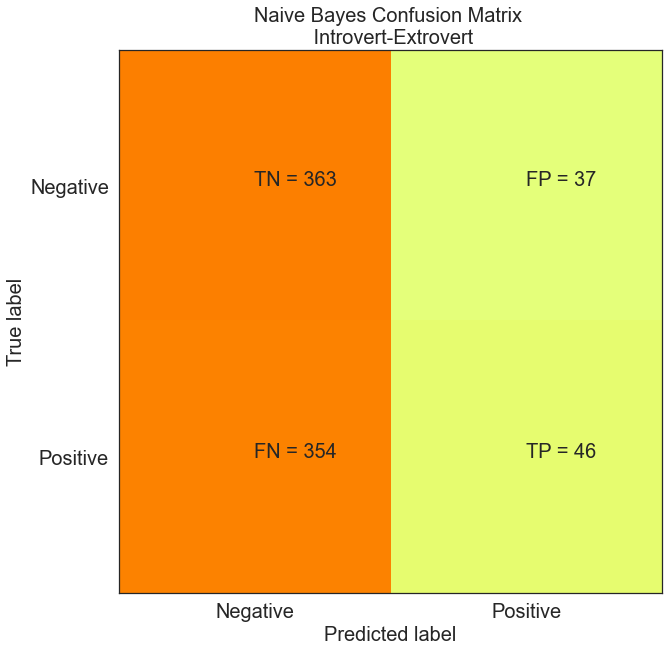

In [40]:
y_test = []
y_pred = []
y_proba = []

for i in test:
    y_test.append(i[1])
    results = IntroExtroClassifier.classify(i[0])
    probability = IntroExtroClassifier.prob_classify(i[0])
    probability_list = []
    
    for label in probability.samples():
        probability_list.append(probability.prob(label))
    
    y_proba.append(probability_list)
    y_pred.append(results)

get_confusion_matrix(y_test, y_pred, 'Naive Bayes Confusion Matrix \n Introvert-Extrovert')

In [41]:
get_classification_report(y_test, y_pred)

Accuracy = 0.51125
Precision = 0.5542168674698795
Recall = 0.115
F1_score = 0.19047619047619047
Specificity = 0.9075
False Positive Rate = 0.0925
False Negative Rate = 0.885


Naive Bayes Introvert-Extrovert ROC AUC: 0.6143


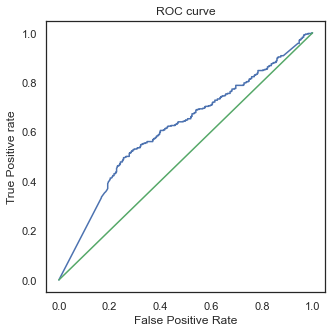

In [42]:
y_proba=np.array([np.array(xi) for xi in y_proba])
y_pred = [1 if i == "Extrovert" else 0 for i in y_pred]
y_test = [1 if i == "Extrovert" else 0 for i in y_test]

plot_sklearn_roc_curve(y_test, y_proba[:, 1])
score = roc_auc_score(y_test, y_proba[:, 1])
print(f"Naive Bayes Introvert-Extrovert ROC AUC: {score:.4f}")

In [43]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, y_proba[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [44]:
informative_features = show_most_informative_features_in_list(IntroExtroClassifier, 10)

Extrovert :  ['competing', 'viva', 'flighty', 'pony', 'bucket', 'hunch', 'orgasm', 'oscar', 'urban', 'eighteen']
Introvert :  ['cancel', 'edward', 'adulthood', 'valley', 'flags', 'pajamas', 'rhythm', 'salad', 'geography', 'lengths']


##### XGBoost

In [45]:
xg_boost_ie, y_test, y_pred, y_proba = xgboost_classifier(intro_extro_df, 'Introvert_Extrovert', 'Introvert')

c:\Users\zheny\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 72.00%


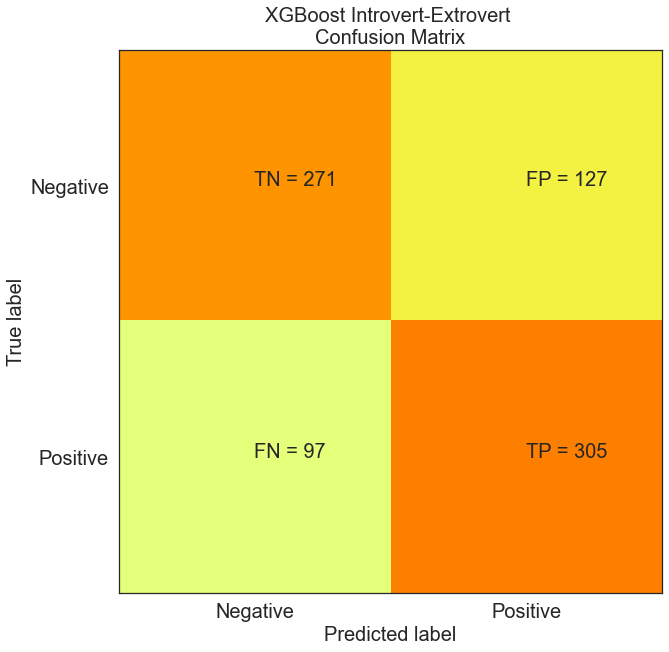

In [46]:
get_confusion_matrix(y_test, y_pred, 'XGBoost Introvert-Extrovert \nConfusion Matrix')

In [47]:
get_classification_report(y_test, y_pred)

Accuracy = 0.72
Precision = 0.7060185185185185
Recall = 0.7587064676616916
F1_score = 0.7314148681055155
Specificity = 0.6809045226130653
False Positive Rate = 0.31909547738693467
False Negative Rate = 0.24129353233830847


In [48]:
fpr2, tpr2, thresh2 = roc_curve(y_test, y_proba[:,1], pos_label=1)

ROC AUC: 0.7895


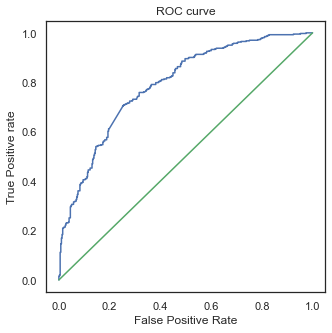

In [49]:
plot_sklearn_roc_curve(y_test, y_proba[:, 1])
score = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {score:.4f}")

##### Combined ROC AUC Curve

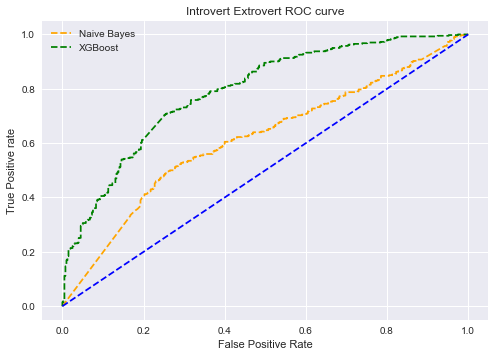

In [50]:
plot_AUC('Introvert Extrovert', fpr1, tpr1, fpr2, tpr2, p_fpr, p_tpr)

### Intuition-Sensing

##### Naive Bayes

In [51]:
intuition_sensing_df = balance_dataset(MBTI_personalities, 'Intuition_Sensing')
bag_of_words_features = build_bag_of_words_features_filtered

features = feature_creation(intuition_sensing_df, bag_of_words_features, 'Intuition_Sensing')
train, test = train_test(features)

IntuitionSensingClassifier = NaiveBayesClassifier.train(train)

training_accuracy = nltk.classify.util.accuracy(IntuitionSensingClassifier, train)*100
testing_accuracy = nltk.classify.util.accuracy(IntuitionSensingClassifier, test)*100
print(f"Training accuracy is: {training_accuracy}")
print(f"Testing accuracy is: {testing_accuracy}")

2394
Training accuracy is: 94.30512016718914
Testing accuracy is: 62.083333333333336


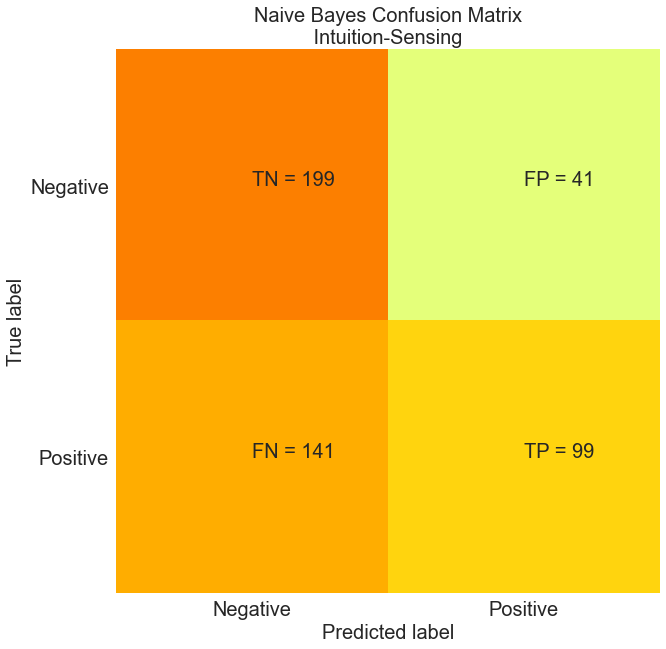

In [52]:
y_test = []
y_pred = []
y_proba = []

for i in test:
    y_test.append(i[1])
    results = IntuitionSensingClassifier.classify(i[0])
    probability = IntuitionSensingClassifier.prob_classify(i[0])
    probability_list = []
    
    for label in probability.samples():
        probability_list.append(probability.prob(label))
    
    y_proba.append(probability_list)
    y_pred.append(results)
    
get_confusion_matrix(y_test, y_pred, 'Naive Bayes Confusion Matrix\n Intuition-Sensing ')

In [53]:
get_classification_report(y_test, y_pred)

Accuracy = 0.6208333333333333
Precision = 0.7071428571428572
Recall = 0.4125
F1_score = 0.5210526315789473
Specificity = 0.8291666666666667
False Positive Rate = 0.17083333333333334
False Negative Rate = 0.5875


ROC AUC: 0.6972


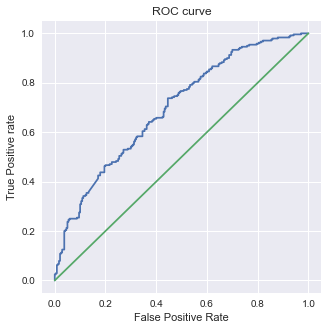

In [54]:
y_proba=np.array([np.array(xi) for xi in y_proba])
y_pred = [1 if i == "Sensing" else 0 for i in y_pred]
y_test = [1 if i == "Sensing" else 0 for i in y_test]

plot_sklearn_roc_curve(y_test, y_proba[:, 1])
score = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {score:.4f}")

In [55]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, y_proba[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [56]:
informative_features = show_most_informative_features_in_list(IntuitionSensingClassifier, 10)

Sensing :  ['niss', 'rave', 'phlegmatic', '47', 'teams', 'clique', 'dirt', 'labor', 'movements', 'smiley']
Intuition :  ['domination', 'crystal', 'heroes', 'shocking', 'wandering', 'einstein', 'illusion', 'kindly', 'needless', 'phd']


##### XGBoost

In [57]:
xg_boost_ns, y_test, y_pred, y_proba = xgboost_classifier(intuition_sensing_df, 'Intuition_Sensing', 'Intuition')

c:\Users\zheny\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 72.03%


In [58]:
fpr2, tpr2, thresh2 = roc_curve(y_test, y_proba[:,1], pos_label=1)

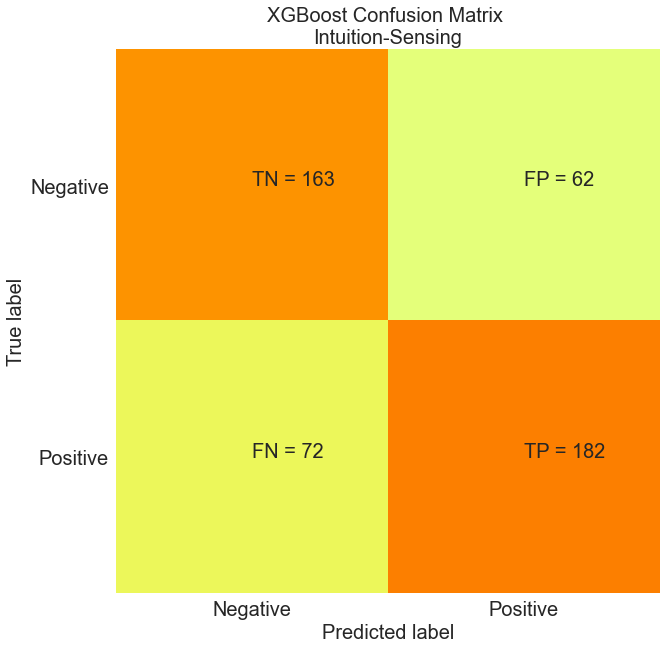

In [59]:
get_confusion_matrix(y_test, y_pred, 'XGBoost Confusion Matrix \nIntuition-Sensing')

In [60]:
get_classification_report(y_test, y_pred)

Accuracy = 0.7202505219206681
Precision = 0.7459016393442623
Recall = 0.7165354330708661
F1_score = 0.7309236947791163
Specificity = 0.7244444444444444
False Positive Rate = 0.27555555555555555
False Negative Rate = 0.28346456692913385


ROC AUC: 0.8086


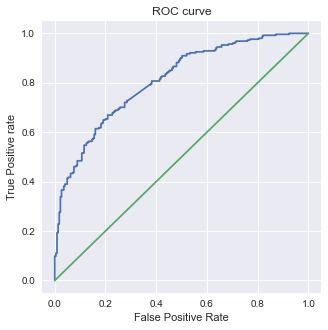

In [61]:
plot_sklearn_roc_curve(y_test, y_proba[:, 1])
score = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {score:.4f}")

##### Combined ROC AUC Curve

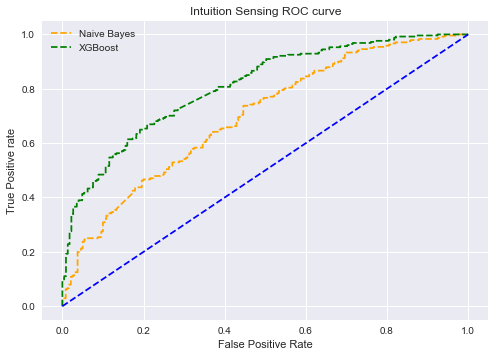

In [62]:
plot_AUC('Intuition Sensing', fpr1, tpr1, fpr2, tpr2, p_fpr, p_tpr)

### Thinking-Feeling

##### Naive Bayes

In [63]:
thinking_feeling_df = balance_dataset(MBTI_personalities, 'Thinking_Feeling')
bag_of_words_features = build_bag_of_words_features_filtered

features = feature_creation(thinking_feeling_df, bag_of_words_features, 'Thinking_Feeling')
train, test = train_test(features)

ThinkingFeelingClassifier = NaiveBayesClassifier.train(train)

training_accuracy = nltk.classify.util.accuracy(ThinkingFeelingClassifier, train)*100
testing_accuracy = nltk.classify.util.accuracy(ThinkingFeelingClassifier, test)*100

print(f"Training accuracy is: {training_accuracy}")
print(f"Testing accuracy is: {testing_accuracy}")

7962
Training accuracy is: 92.38379396984925
Testing accuracy is: 74.15307402760351


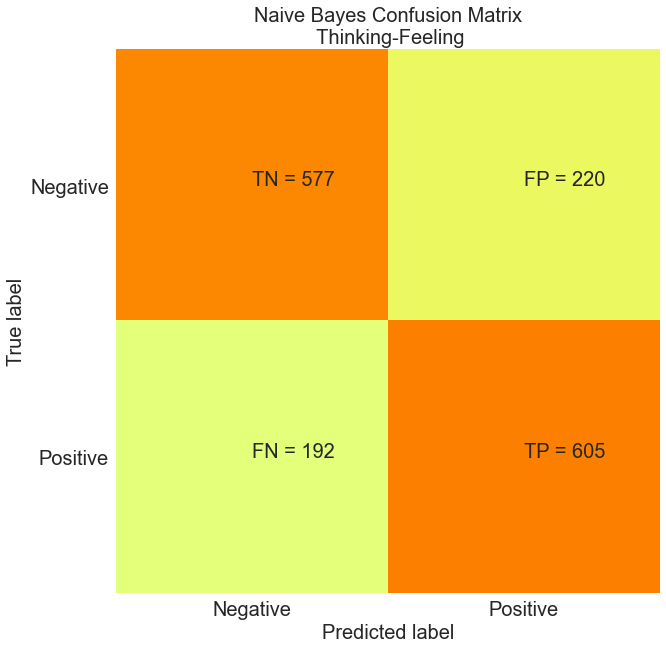

In [64]:
y_test = []
y_pred = []
y_proba = []

for i in test:
    y_test.append(i[1])
    results = ThinkingFeelingClassifier.classify(i[0])
    probability = ThinkingFeelingClassifier.prob_classify(i[0])
    probability_list = []
    
    for label in probability.samples():
        probability_list.append(probability.prob(label))
    
    y_proba.append(probability_list)
    y_pred.append(results)
    
get_confusion_matrix(y_test, y_pred, 'Naive Bayes Confusion Matrix\n Thinking-Feeling')

In [65]:
get_classification_report(y_test, y_pred)

Accuracy = 0.7415307402760352
Precision = 0.7333333333333333
Recall = 0.7590966122961104
F1_score = 0.7459926017262638
Specificity = 0.7239648682559598
False Positive Rate = 0.27603513174404015
False Negative Rate = 0.24090338770388958


ROC AUC: 0.8142


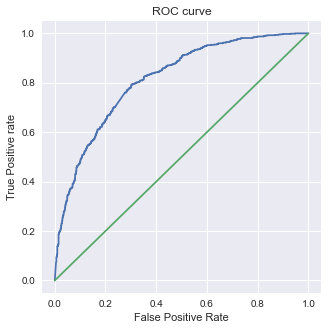

In [66]:
y_proba=np.array([np.array(xi) for xi in y_proba])
y_pred = [1 if i == "Thinking" else 0 for i in y_pred]
y_test = [1 if i == "Thinking" else 0 for i in y_test]

plot_sklearn_roc_curve(y_test, y_proba[:, 1])
score = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {score:.4f}")

In [67]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, y_proba[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [68]:
informative_features = show_most_informative_features_in_list(ThinkingFeelingClassifier, 10)

Thinking :  ['inefficient', 'rand', 'reports', 'java', 'lined', 'quantitative', 'communist', 'intermediate', 'sock', 'usefulness']
Feeling :  ['adored', 'viva', 'cozy', 'vividly', 'gandhi', 'pixie', 'rug', 'musically', 'shattered', 'unity']


##### XGBoost

In [69]:
xg_boost_tf, y_test, y_pred, y_proba = xgboost_classifier(thinking_feeling_df, 'Thinking_Feeling', 'Thinking')

c:\Users\zheny\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 73.82%


In [70]:
fpr2, tpr2, thresh2 = roc_curve(y_test, y_proba[:,1], pos_label=1)

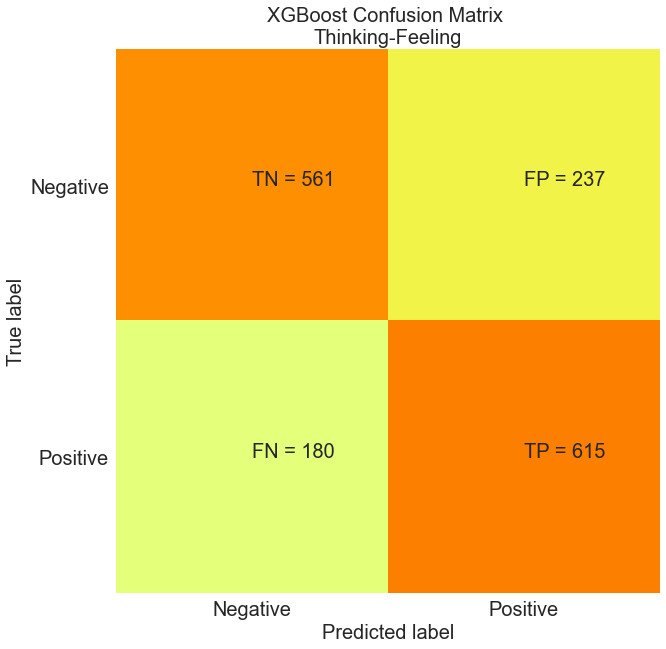

In [71]:
get_confusion_matrix(y_test, y_pred, 'XGBoost Confusion Matrix \nThinking-Feeling')

In [72]:
get_classification_report(y_test, y_pred)

Accuracy = 0.7382297551789078
Precision = 0.721830985915493
Recall = 0.7735849056603774
F1_score = 0.7468123861566485
Specificity = 0.7030075187969925
False Positive Rate = 0.29699248120300753
False Negative Rate = 0.22641509433962265


ROC AUC: 0.8369


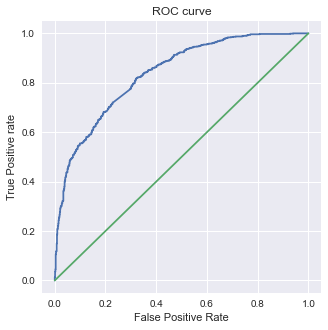

In [73]:
plot_sklearn_roc_curve(y_test, y_proba[:, 1])
score = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {score:.4f}")

##### Combined ROC AUC Curve

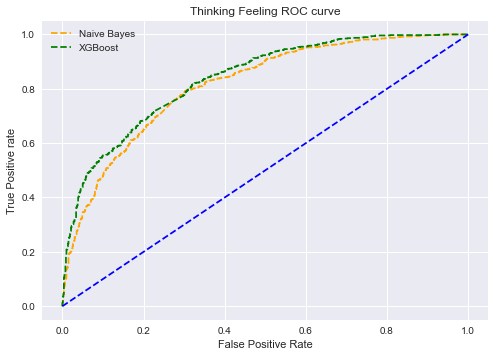

In [74]:
plot_AUC('Thinking Feeling', fpr1, tpr1, fpr2, tpr2, p_fpr, p_tpr)

### Judging-Perceiving

##### Naive Bayes

In [126]:
judging_perceiving_df = balance_dataset(MBTI_personalities, 'Judging_Perceiving')
bag_of_words_features = build_bag_of_words_features_filtered

features = feature_creation(judging_perceiving_df, bag_of_words_features, 'Judging_Perceiving')
train, test = train_test(features)

JudgingPerceivingClassifier = NaiveBayesClassifier.train(train)

training_accuracy = nltk.classify.util.accuracy(JudgingPerceivingClassifier, train)*100
testing_accuracy = nltk.classify.util.accuracy(JudgingPerceivingClassifier, test)*100
print(f"Training accuracy is: {training_accuracy}")
print(f"Testing accuracy is: {testing_accuracy}")

6868
Training accuracy is: 82.6538041499818
Testing accuracy is: 53.78457059679768


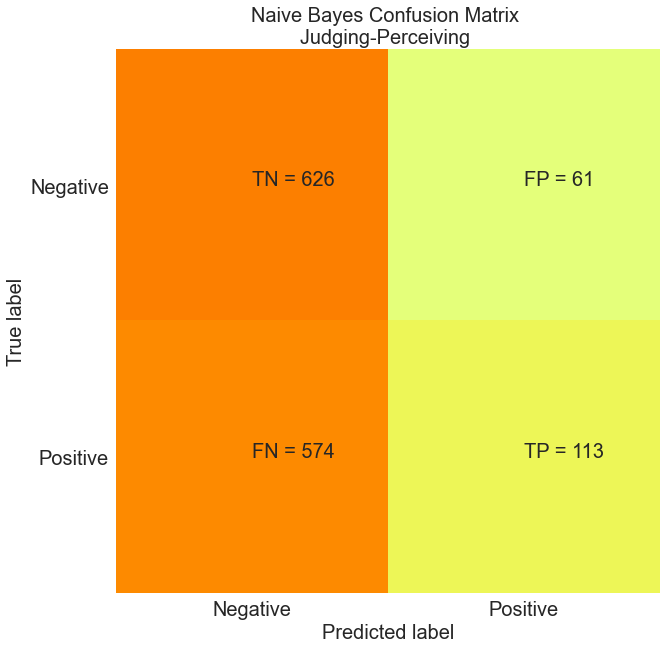

In [122]:
y_test = []
y_pred = []
y_proba = []

for i in test:
    y_test.append(i[1])
    results = JudgingPerceivingClassifier.classify(i[0])
    probability = JudgingPerceivingClassifier.prob_classify(i[0])
    probability_list = []
    
    for label in probability.samples():
        probability_list.append(probability.prob(label))
    
    y_proba.append(probability_list)
    y_pred.append(results)
    
get_confusion_matrix(y_test, y_pred, 'Naive Bayes Confusion Matrix \nJudging-Perceiving ')

In [123]:
get_classification_report(y_test, y_pred)

Accuracy = 0.5378457059679768
Precision = 0.6494252873563219
Recall = 0.16448326055312956
F1_score = 0.26248548199767713
Specificity = 0.9112081513828238
False Positive Rate = 0.08879184861717612
False Negative Rate = 0.8355167394468704


ROC AUC: 0.6070


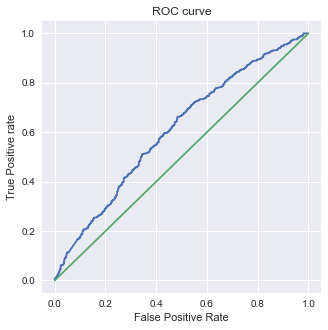

In [124]:
y_proba=np.array([np.array(xi) for xi in y_proba])
y_pred = [1 if i == "Perceiving" else 0 for i in y_pred]
y_test = [1 if i == "Perceiving" else 0 for i in y_test]

plot_sklearn_roc_curve(y_test, y_proba[:, 1])
score = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {score:.4f}")

In [125]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, y_proba[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [80]:
informative_features = show_most_informative_features_in_list(JudgingPerceivingClassifier, 10)

Judging :  ['copies', 'promotion', 'assurance', 'delving', 'gauging', 'impacted', 'malice', 'measurable', 'warfare', 'arrive']
Perceiving :  ['stoned', 'lennon', 'rug', 'sailing', 'brotherhood', 'drawer', 'libertarianism', 'magnificent', 'oregon', 'rested']


##### XGBoost

In [81]:
xg_boost_jp, y_test, y_pred, y_proba  = xgboost_classifier(judging_perceiving_df, 'Judging_Perceiving', 'Judging')

c:\Users\zheny\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 72.56%


In [82]:
fpr2, tpr2, thresh2 = roc_curve(y_test, y_proba[:,1], pos_label=1)

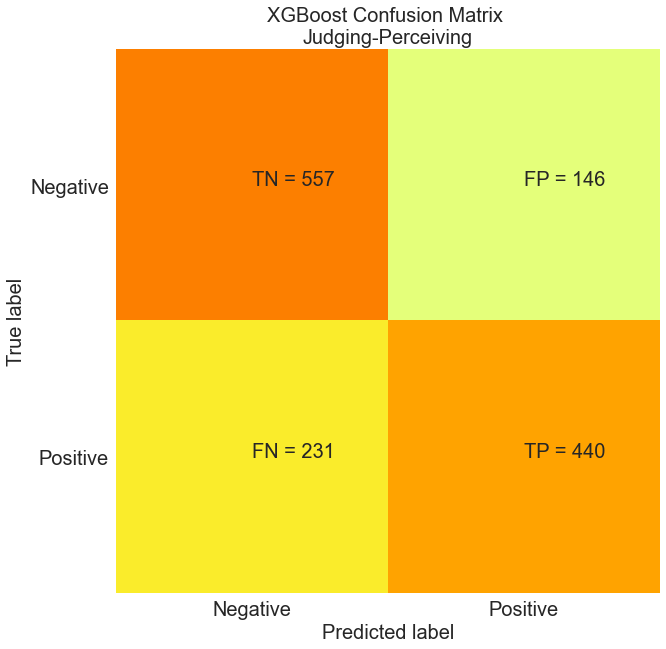

In [83]:
get_confusion_matrix(y_test, y_pred, 'XGBoost Confusion Matrix \nJudging-Perceiving')

In [84]:
get_classification_report(y_test, y_pred)

Accuracy = 0.7256186317321689
Precision = 0.7508532423208191
Recall = 0.6557377049180327
F1_score = 0.700079554494829
Specificity = 0.7923186344238976
False Positive Rate = 0.20768136557610242
False Negative Rate = 0.3442622950819672


ROC AUC: 0.8056


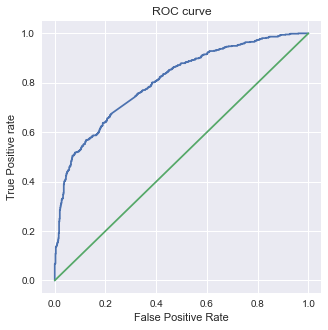

In [85]:
plot_sklearn_roc_curve(y_test, y_proba[:, 1])
score = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {score:.4f}")

##### Combined ROC AUC Curve

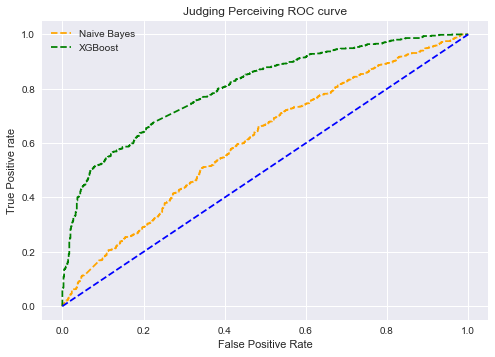

In [86]:
plot_AUC('Judging Perceiving', fpr1, tpr1, fpr2, tpr2, p_fpr, p_tpr)

### Innovative vs Traditional

In [87]:
innovative_traditional_data = pd.read_sql_query('''select * from Innovative_Traditional_Companies''', connection)
innovative_traditional_data['posts'] = innovative_traditional_data['posts'].astype(str)
innovative_traditional_data.head()

c:\Users\zheny\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,posts,company,type
0,According to our annual Shop Small Research f...,American Express,innovative
1,"Weitian Chan, second generation owner of Pres...",American Express,innovative
2,Local businesses play a huge role in the live...,American Express,innovative
3,"Lawrence Chow, founder of bicycle shop B-Spok...",American Express,innovative
4,"We want to give a shoutout to our customers, ...",American Express,innovative


In [88]:
innovative_traditional_df = balance_dataset(innovative_traditional_data, 'type')
bag_of_words_features = build_bag_of_words_features_filtered

features = feature_creation(innovative_traditional_df, bag_of_words_features, 'type')
train, test = train_test(features)

InnovativeTraditionalClassifier = NaiveBayesClassifier.train(train)

training_accuracy = nltk.classify.util.accuracy(InnovativeTraditionalClassifier, train)*100
testing_accuracy = nltk.classify.util.accuracy(InnovativeTraditionalClassifier, test)*100
print(f"Training accuracy is: {training_accuracy}")
print(f"Testing accuracy is: {testing_accuracy}")

2246
Training accuracy is: 99.38752783964365
Testing accuracy is: 91.11111111111111


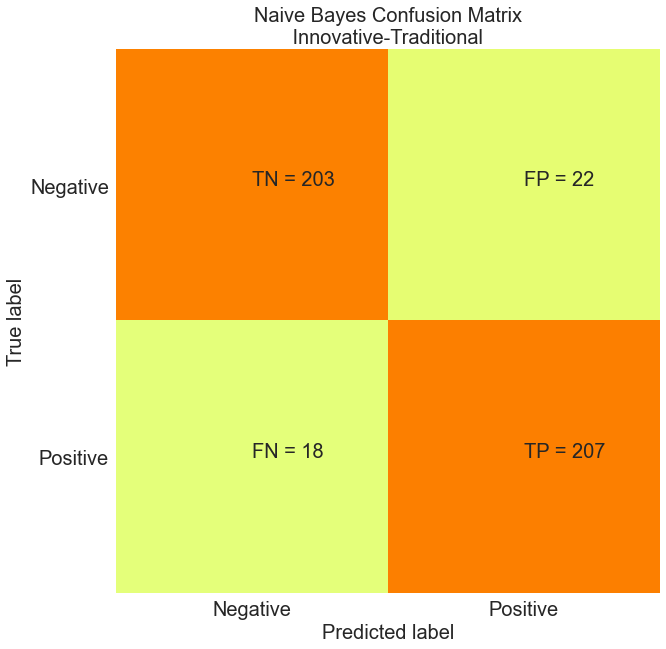

In [89]:
y_test = []
y_pred = []
y_proba = []

for i in test:
    y_test.append(i[1])
    results = InnovativeTraditionalClassifier.classify(i[0])
    probability = InnovativeTraditionalClassifier.prob_classify(i[0])
    probability_list = []
    
    for label in probability.samples():
        probability_list.append(probability.prob(label))
    
    y_proba.append(probability_list)
    y_pred.append(results)
    
get_confusion_matrix(y_test, y_pred, 'Naive Bayes Confusion Matrix\n Innovative-Traditional ')

In [90]:
get_classification_report(y_test, y_pred)

Accuracy = 0.9111111111111111
Precision = 0.9039301310043668
Recall = 0.92
F1_score = 0.9118942731277534
Specificity = 0.9022222222222223
False Positive Rate = 0.09777777777777778
False Negative Rate = 0.08


ROC AUC: 0.9774


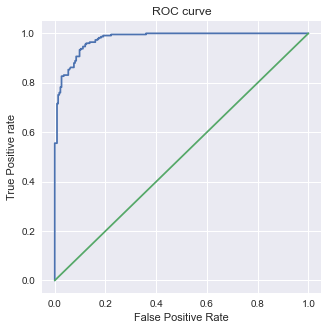

In [91]:
y_proba=np.array([np.array(xi) for xi in y_proba])
y_pred = [1 if i == "traditional" else 0 for i in y_pred]
y_test = [1 if i == "traditional" else 0 for i in y_test]

plot_sklearn_roc_curve(y_test, y_proba[:, 1])
score = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {score:.4f}")

In [92]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, y_proba[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [93]:
informative_features = show_most_informative_features_in_list(InnovativeTraditionalClassifier, 10)

traditional :  ['associates', 'P', 'gas', 'capture', 'Sam', 'patient', 'treatment', 'vaccines', 'patients', 'Energy']
innovative :  ['Express', 'Customer', 'Software', 'fulfillment', 'Small', 'Partner', 'Tech', 'Apply', 'cards', 'Come']


##### XGBoost

In [94]:
xg_boost_it, y_test, y_pred, y_proba = xgboost_classifier(innovative_traditional_df, 'type', 'innovative')

c:\Users\zheny\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 94.22%


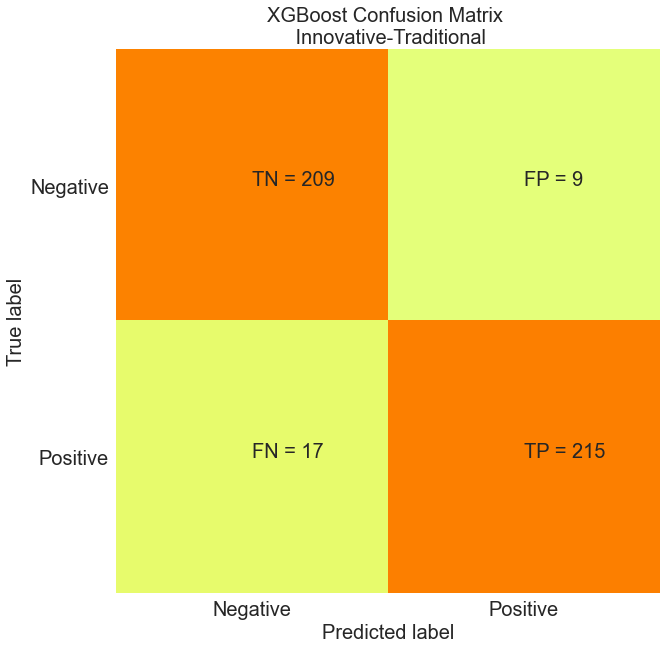

In [95]:
get_confusion_matrix(y_test, y_pred, 'XGBoost Confusion Matrix \n Innovative-Traditional')

In [96]:
get_classification_report(y_test, y_pred)

Accuracy = 0.9422222222222222
Precision = 0.9598214285714286
Recall = 0.9267241379310345
F1_score = 0.9429824561403509
Specificity = 0.9587155963302753
False Positive Rate = 0.04128440366972477
False Negative Rate = 0.07327586206896551


ROC AUC: 0.9861


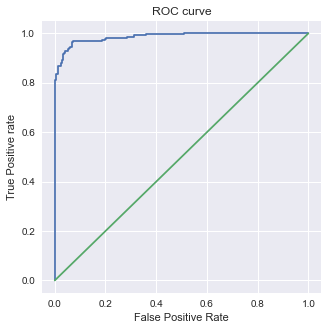

In [97]:
# Plots the ROC curve using the sklearn methods - Good plot
plot_sklearn_roc_curve(y_test, y_proba[:, 1])
score = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {score:.4f}")

##### Combined ROC AUC Curve

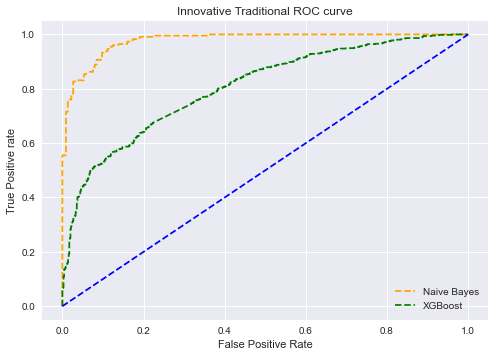

In [98]:
plot_AUC('Innovative Traditional', fpr1, tpr1, fpr2, tpr2, p_fpr, p_tpr)

In [99]:
# save to JSON
xg_boost_ie.save_model("../Models/xg_boost_ie.json")
xg_boost_ns.save_model("../Models/xg_boost_ns.json")
xg_boost_jp.save_model("../Models/xg_boost_jp.json")
xg_boost_tf.save_model("../Models/xg_boost_tf.json")
xg_boost_it.save_model("../Models/xg_boost_it.json")

### Apply to dataset

In [100]:
glassdoor_data = pd.read_sql_query('''select * from Company_Glassdoor_Data''', connection)
glassdoor_data.head()

c:\Users\zheny\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,headline,date,year exp,score,pros,cons,company,position
0,Great company to work,2022-09-08,"Current Employee, less than 1 year",5.0,"Great Benefit, no 996, good working environment",sometimes the communication still in Chinese b...,TikTok,Anonymous Employee
1,Good but not great. Self driven is a must,2022-09-08,"Current Employee, more than 1 year",4.0,Good benefits and fast growing,Need to be very self driven and street smart,TikTok,Business Operations Analyst
2,"A fast growing, diverse and inclusive workplace",2022-09-07,Current Employee,5.0,- Great emphasis on staff well being\r\n- Regu...,- Infrastructure can be further improved (Faci...,TikTok,Anonymous Employee
3,PM,2022-08-29,Current Employee,5.0,Good Atmosphere and excellent teamwork,So far so good and nothing special to mention,TikTok,Product Designer
4,Nice for u if you like coop with young people,2022-08-21,"Current Employee, more than 1 year",4.0,"the company is filled with young people, very ...",Might need to OT when you oncall\r\nsome bosse...,TikTok,Quality Assurance Engineer


In [101]:
glassdoor_data['raw_reviews'] = glassdoor_data['pros'] + glassdoor_data['cons']

In [102]:
for row in glassdoor_data.itertuples():
    input = row.raw_reviews 
    tokenize = build_bag_of_words_features_filtered(input)
    
    # Classify text
    ie = IntroExtroClassifier.classify(tokenize)
    ns = IntuitionSensingClassifier.classify(tokenize)
    tf = ThinkingFeelingClassifier.classify(tokenize)
    jp = JudgingPerceivingClassifier.classify(tokenize)
    it = InnovativeTraditionalClassifier.classify(tokenize)
    
    glassdoor_data.loc[row.Index, 'Introvert_Extrovert'] = ie
    glassdoor_data.loc[row.Index, 'Intuition_Sensing'] = ns
    glassdoor_data.loc[row.Index, 'Thinking_Feeling'] = tf
    glassdoor_data.loc[row.Index, 'Judging_Perceiving'] = jp
    glassdoor_data.loc[row.Index, 'Innovative_Traditional'] = it
    

In [103]:
display(glassdoor_data['Introvert_Extrovert'].value_counts())
display(glassdoor_data['Intuition_Sensing'].value_counts())
display(glassdoor_data['Thinking_Feeling'].value_counts())
display(glassdoor_data['Judging_Perceiving'].value_counts())
display(glassdoor_data['Innovative_Traditional'].value_counts())

Extrovert    1278
Introvert     432
Name: Introvert_Extrovert, dtype: int64

Intuition    886
Sensing      824
Name: Intuition_Sensing, dtype: int64

Thinking    1278
Feeling      432
Name: Thinking_Feeling, dtype: int64

Judging       1417
Perceiving     293
Name: Judging_Perceiving, dtype: int64

innovative     919
traditional    791
Name: Innovative_Traditional, dtype: int64

In [104]:
company_data = glassdoor_data.copy()

In [105]:
company_data.head()

,headline,date,year exp,score,pros,cons,company,position,raw_reviews,Introvert_Extrovert,Intuition_Sensing,Thinking_Feeling,Judging_Perceiving,Innovative_Traditional
0,Great company to work,2022-09-08,"Current Employee, less than 1 year",5.0,"Great Benefit, no 996, good working environment",sometimes the communication still in Chinese b...,TikTok,Anonymous Employee,"Great Benefit, no 996, good working environmen...",Extrovert,Sensing,Feeling,Judging,traditional
1,Good but not great. Self driven is a must,2022-09-08,"Current Employee, more than 1 year",4.0,Good benefits and fast growing,Need to be very self driven and street smart,TikTok,Business Operations Analyst,Good benefits and fast growingNeed to be very ...,Extrovert,Sensing,Thinking,Judging,innovative
2,"A fast growing, diverse and inclusive workplace",2022-09-07,Current Employee,5.0,- Great emphasis on staff well being\r\n- Regu...,- Infrastructure can be further improved (Faci...,TikTok,Anonymous Employee,- Great emphasis on staff well being\r\n- Regu...,Extrovert,Sensing,Thinking,Judging,traditional
3,PM,2022-08-29,Current Employee,5.0,Good Atmosphere and excellent teamwork,So far so good and nothing special to mention,TikTok,Product Designer,Good Atmosphere and excellent teamworkSo far s...,Extrovert,Intuition,Thinking,Judging,traditional
4,Nice for u if you like coop with young people,2022-08-21,"Current Employee, more than 1 year",4.0,"the company is filled with young people, very ...",Might need to OT when you oncall\r\nsome bosse...,TikTok,Quality Assurance Engineer,"the company is filled with young people, very ...",Extrovert,Sensing,Thinking,Judging,innovative


In [106]:
company_data['Personality_IE'] = company_data['Introvert_Extrovert'].apply(lambda x: 'I' if x == 'Introvert' else 'E')
company_data['Personality_NS'] = company_data['Intuition_Sensing'].apply(lambda x: 'N' if x == 'Intuition' else 'S')
company_data['Personality_JP'] = company_data['Judging_Perceiving'].apply(lambda x: 'J' if x == 'Judging' else 'P')
company_data['Personality_TF'] = company_data['Thinking_Feeling'].apply(lambda x: 'T' if x == 'Thinking' else 'F')
company_data['Personality'] = company_data['Personality_IE'] + company_data['Personality_NS'] + company_data['Personality_JP'] + company_data['Personality_TF']
company_data.drop(columns = ['Personality_IE', 'Personality_NS', 'Personality_JP', 'Personality_TF'], inplace = True)

In [107]:
def emotions_lexicon(company_data, emotion_lexicon_df):
    from nltk.corpus import brown, stopwords
    from nltk.stem.snowball import SnowballStemmer
    import nltk
    import string
    import pandas as pd
    import streamlit as st

    company_data['reviews'] = company_data['pros'] + company_data['cons']
    company_data['reviews'] = company_data['reviews'].str.lower()
    stop = stopwords.words('english')
    company_data['reviews'] = company_data['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    company_data["reviews"] = company_data['reviews'].str.replace('[^\w\s]','')
    
    emotion_dict = emotion_lexicon_df.to_dict('records')
    
    def lemmatize_text(text):    
        stemmer = SnowballStemmer('english')
        w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
        lemmatizer = nltk.stem.WordNetLemmatizer()
        x = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text) if w_tokenizer.tokenize(text) != ',']
        x = [''.join(c for c in s if c not in string.punctuation) for s in x]
        x = [stemmer.stem(word.lower()) for word in x]
        
        return x
    
    def transform_list(x):
        emotion_list = [next((item for item in emotion_dict if item["Word"] == i), None) for i in x]
        return emotion_list

    def sum_dict_values(dict_list):
        dict_list = [x for x in dict_list if x is not None]
        result = {}
        for d in dict_list:
            for k, v in d.items():
                if k != 'Word' and isinstance(v, int):
                    result[k] = result.get(k, 0) + v
        return result    


    company_data['emotions'] = company_data['reviews'].apply(lemmatize_text)
    company_data['emotions'] = company_data['emotions'].apply(transform_list)
    company_data['emotions'] = company_data['emotions'].apply(sum_dict_values)
    company_data = pd.concat([company_data, company_data['emotions'].apply(pd.Series)], axis = 1)
            
    exclusive_list = ['Anger', 'Fear', 'Disgust']
    openness_list = ['Joy', 'Trust', 'Anticipation']
    company_data['is_exclusive'] = company_data[exclusive_list].sum(axis = 1)
    company_data['is_open'] = company_data[openness_list].sum(axis = 1)
    company_data['exclusive_openness'] = company_data.apply(lambda x: 'Exclusive' if (x['is_exclusive'] > x['is_open']) else 'Open', axis = 1)
    try:
        company_data['score'] = company_data['score'].astype(int)
    except KeyError as e:
        pass
    
    return company_data

In [108]:
company_data = emotions_lexicon(company_data, emotion_lexicon_df)

C:\Users\zheny\AppData\Local\Temp\ipykernel_10000\1630425534.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  company_data["reviews"] = company_data['reviews'].str.replace('[^\w\s]','')
C:\Users\zheny\AppData\Local\Temp\ipykernel_10000\1630425534.py:44: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  company_data = pd.concat([company_data, company_data['emotions'].apply(pd.Series)], axis = 1)
C:\Users\zheny\AppData\Local\Temp\ipykernel_10000\1630425534.py:44: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  company_data = pd.concat([company_data, company_data['emotions'].apply(pd.Series)], axis = 1)
C:\Users\zheny\AppData\Local\Temp\ipykernel_10000\1630425534.py:44: FutureWarning: The default dtype for empty

In [109]:
emotions_list = ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
values_list = company_data[emotions_list].sum().tolist()
data_list = []
for i in range(len(emotions_list)):
    temp_list = []
    temp_list.append(emotions_list[i])
    temp_list.append(values_list[i])
    data_list.append(temp_list)

company_data[['Positive', 'Negative', 'Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust', 'is_exclusive', 'is_open']] = company_data[['Positive', 'Negative', 'Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust', 'is_exclusive', 'is_open']].astype('Int64')

In [110]:
company_data.to_csv('company_data_cleaned.csv')

In [111]:
n = 5
top5_list = company_data['position'].value_counts()[:n].index.tolist()
filter_dataframe = company_data[company_data['position'].isin(top5_list)]

In [112]:
avg_score_df = filter_dataframe.groupby(['position'])['score'].mean().round(2).reset_index()
avg_score_df

,position,score
0,Anonymous Employee,4.09
1,Auxiliary Police Officer,2.73
2,Manager,4.11
3,Senior Software Engineer,4.00
4,Software Engineer,4.21


In [113]:
count_df = filter_dataframe['position'].value_counts().round(2).reset_index()
count_df.columns = ['position', 'count']

In [114]:
combined_df = pd.merge(avg_score_df, count_df, on = ['position'], how = 'left')
print(combined_df)

                    position  score  count
0         Anonymous Employee   4.09    301
1   Auxiliary Police Officer   2.73     30
2                    Manager   4.11     44
3   Senior Software Engineer   4.00     32
4          Software Engineer   4.21     67


In [115]:
combined_df.values.tolist()

[[' Anonymous Employee', 4.09, 301],
 [' Auxiliary Police Officer', 2.73, 30],
 [' Manager', 4.11, 44],
 [' Senior Software Engineer', 4.0, 32],
 [' Software Engineer', 4.21, 67]]

In [116]:
import plotly.express as px

fig = px.bar(combined_df, x="position", y="count", text="score")
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()